In [1]:
import os
import glob
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

In [3]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)
chen_metadata.head(1)

,Accession,SampleID,PatientID,TreatmentStage,TreatmentPoint,BiopsySite,MMR,MSI,TMB,Response,LibraryType,TumorLocation,CancerType
0,HRR1372976,P04-N-I,P04,Pre,Baseline,Normal,dMMR,MSI,487,CR,scRNA-seq,Ascending colon,CRC


## Chen et al

### Process Tumor NanoMnT outputs

In [6]:
DIR_tumor_cellranger_out = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor_merged'

In [58]:
alleleTable = list()

for SampleID, edf in chen_metadata[(chen_metadata['BiopsySite']=='Tumor') & (chen_metadata['TreatmentStage']=='Pre')].groupby("SampleID"):
    PATH_alleleTable = f'{DIR_tumor_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
    PATH_processed_alleleTable = f'{DIR_tumor_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    
    if os.path.exists(PATH_processed_alleleTable) == True:
        alleleTable_temp = pd.read_csv(PATH_processed_alleleTable, sep='\t')
        alleleTable.append(alleleTable_temp)
    
    elif os.path.exists(PATH_alleleTable) == True:
        alleleTable_temp = pd.read_csv(PATH_alleleTable, sep='\t')
        alleleTable_temp['SampleID'] = SampleID
        orig_length = len(alleleTable_temp)

        ### 1. Filter out low-quality flankings (e.g., indels within flankings)        
        col_flanking_quality = list()
        for tup2 in alleleTable_temp.itertuples():
            bf = f'{tup2.left_flanking_seq}{tup2.right_flanking_seq}'
            if '*' in bf:
                col_flanking_quality.append( 'Poor' )
            elif bf.upper() != bf:
                col_flanking_quality.append( 'Poor' )
            else:
                col_flanking_quality.append( 'Good' )
                
        alleleTable_temp['flanking_quality'] = col_flanking_quality
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['flanking_quality']=='Good')].copy()
        
        ### 2. Filter out G/C repeats
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['repeat_unit'].isin(['A', 'T']))].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')        
        
        ### 3. Filter out reads without CB or UMI
        alleleTable_temp.dropna(inplace=True,)
        alleleTable_temp = alleleTable_temp[alleleTable_temp['reference_STR_allele']<=24].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')
        
        alleleTable_temp['diff'] = alleleTable_temp['read_STR_allele'] - alleleTable_temp['reference_STR_allele']
        alleleTable_temp.to_csv(PATH_processed_alleleTable, sep='\t', index=False)
        alleleTable.append(alleleTable_temp)
    else:
        print(f'Allele table not found for: {SampleID}!')

76.17 %
51.78 %
72.11 %
54.79 %
79.18 %
60.92 %
78.87 %
56.39 %
75.31 %
56.51 %
72.53 %
51.35 %
69.55 %
43.98 %
79.08 %
64.28 %
72.2 %
47.19 %
76.08 %
50.51 %
77.7 %
55.68 %
73.77 %
53.4 %
72.7 %
50.76 %
73.68 %
50.49 %
73.54 %
50.89 %
70.15 %
53.22 %


In [59]:
alleleTable = pd.concat(alleleTable)
alleleTable.reset_index(inplace=True, drop=True)
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in alleleTable.itertuples() ]

In [94]:
alleleTable.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Tumor.NanoMnT.AlleleTable.tsv.gz', sep='\t', index=False, compression='gzip')

In [92]:
alleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Tumor.NanoMnT.AlleleTable.tsv.gz', sep='\t')

In [93]:
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in alleleTable.itertuples() ]

In [95]:
dict_Identifier_to_STRprofile = dict()

for Identifier, edf in alleleTable.groupby("Identifier"):
    edf_o = edf['diff'].dropna()
    if len(edf_o) > 0:
        dict_Identifier_to_STRprofile[Identifier] = [ np.mean(edf_o), np.std(edf_o), len(edf_o) ]

saveWithPickle(dict_Identifier_to_STRprofile, '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al', 'Tumor.dict_Identifier_to_STRprofile')

### Process NAT NanoMnT outputs

In [64]:
DIR_NAT_cellranger_out = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Adjacent_normal_tissue_merged'

In [65]:
alleleTable = list()

for SampleID, edf in chen_metadata[(chen_metadata['BiopsySite']!='Tumor') & (chen_metadata['TreatmentStage']=='Pre')].groupby("SampleID"):
    PATH_alleleTable = f'{DIR_NAT_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
    PATH_processed_alleleTable = f'{DIR_NAT_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    
    if os.path.exists(PATH_processed_alleleTable) == True:
        alleleTable_temp = pd.read_csv(PATH_processed_alleleTable, sep='\t')
        alleleTable.append(alleleTable_temp)
    
    elif os.path.exists(PATH_alleleTable) == True:
        print(f'Unprocessed AlleleTable for: {SampleID}')
        alleleTable_temp['SampleID'] = SampleID
        alleleTable_temp = pd.read_csv(PATH_alleleTable, sep='\t')
        orig_length = len(alleleTable_temp)

        ### 1. Filter out low-quality flankings (e.g., indels within flankings)        
        col_flanking_quality = list()
        for tup2 in alleleTable_temp.itertuples():
            bf = f'{tup2.left_flanking_seq}{tup2.right_flanking_seq}'
            if '*' in bf:
                col_flanking_quality.append( 'Poor' )
            elif bf.upper() != bf:
                col_flanking_quality.append( 'Poor' )
            else:
                col_flanking_quality.append( 'Good' )
                
        alleleTable_temp['flanking_quality'] = col_flanking_quality
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['flanking_quality']=='Good')].copy()
        
        ### 2. Filter out G/C repeats
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['repeat_unit'].isin(['A', 'T']))].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')        
        
        ### 3. Filter out reads without CB or UMI
        alleleTable_temp.dropna(inplace=True,)
        alleleTable_temp = alleleTable_temp[alleleTable_temp['reference_STR_allele']<=24].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')
        
        alleleTable_temp['diff'] = alleleTable_temp['read_STR_allele'] - alleleTable_temp['reference_STR_allele']
        alleleTable_temp.to_csv(PATH_processed_alleleTable, sep='\t', index=False)
        alleleTable.append(alleleTable_temp)
    else:
        print(f'Allele table not found for: {SampleID}!')

Unprocessed AlleleTable for: P04-N-I
72.72 %
52.29 %
Unprocessed AlleleTable for: P08-N-I
73.05 %
53.7 %
Unprocessed AlleleTable for: P11-N-I
79.09 %
56.57 %
Unprocessed AlleleTable for: P12-N-I
76.01 %
53.78 %
Unprocessed AlleleTable for: P15-N-I
74.69 %
59.71 %
Unprocessed AlleleTable for: P16-N-I
73.07 %
51.43 %
Unprocessed AlleleTable for: P17-N-I
67.18 %
47.1 %
Unprocessed AlleleTable for: P18-N-I
77.34 %
57.51 %
Unprocessed AlleleTable for: P19-N-I
76.99 %
54.06 %
Allele table not found for: P20-N-I!
Unprocessed AlleleTable for: P21-N-I
71.18 %
49.82 %
Unprocessed AlleleTable for: P22-N-I
74.02 %
52.53 %
Unprocessed AlleleTable for: P23-N-I
76.08 %
57.25 %
Unprocessed AlleleTable for: P24-N-I
74.88 %
49.93 %
Unprocessed AlleleTable for: P25-N-I
74.66 %
48.78 %
Allele table not found for: P26-N-I!


In [66]:
alleleTable = pd.concat(alleleTable)
alleleTable.reset_index(inplace=True, drop=True)
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in alleleTable.itertuples() ]

In [99]:
alleleTable.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.NanoMnT.AlleleTable.tsv.gz', sep='\t', index=False, compression='gzip')

In [96]:
alleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.NanoMnT.AlleleTable.tsv.gz', sep='\t')

/tmp/ipykernel_58711/2333644754.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  alleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.NanoMnT.AlleleTable.tsv.gz', sep='\t')


In [97]:
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in alleleTable.itertuples() ]

In [98]:
dict_Identifier_to_STRprofile = dict()

for Identifier, edf in alleleTable.groupby("Identifier"):
    edf_o = edf['diff'].dropna()
    if len(edf_o) > 0:
        dict_Identifier_to_STRprofile[Identifier] = [ np.mean(edf_o), np.std(edf_o), len(edf_o) ]

saveWithPickle(dict_Identifier_to_STRprofile, '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al', 'NAT.dict_Identifier_to_STRprofile')

### Overlay results

In [15]:
dict_NAT_Identifier_to_STRprofile   = loadFromPickle( '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.dict_Identifier_to_STRprofile.pickle' )
dict_Tumor_Identifier_to_STRprofile = loadFromPickle( '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Tumor.dict_Identifier_to_STRprofile.pickle' )

In [8]:
dict_NAT_Identifier_to_STRprofile_temp = dict()
for k, v in dict_NAT_Identifier_to_STRprofile.items():
    dict_NAT_Identifier_to_STRprofile_temp[ '-'.join(k.split('-')[:-1])] = v
dict_NAT_Identifier_to_STRprofile = dict_NAT_Identifier_to_STRprofile_temp
    
dict_Tumor_Identifier_to_STRprofile_temp = dict()
for k, v in dict_Tumor_Identifier_to_STRprofile.items():
    dict_Tumor_Identifier_to_STRprofile_temp[ '-'.join(k.split('-')[:-1])] = v
dict_Tumor_Identifier_to_STRprofile = dict_Tumor_Identifier_to_STRprofile_temp

In [9]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.h5ad')

In [23]:
len(dict_NAT_Identifier_to_STRprofile), len(dict_Tumor_Identifier_to_STRprofile)

(708799, 972152)

In [16]:
dict_Identifier_to_STRprofile = dict()
for k, v in dict_Tumor_Identifier_to_STRprofile.items():
    dict_Identifier_to_STRprofile[k]=v
    
for k, v in dict_NAT_Identifier_to_STRprofile.items():
    dict_Identifier_to_STRprofile[k]=v

for Identifier in adata.obs['Identifier']:
    try: dict_Identifier_to_STRprofile[Identifier]
    except KeyError: dict_Identifier_to_STRprofile[Identifier]=[0, 0, 0]

In [18]:
adata.obs['AvgSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][0] for Identifier in adata.obs['Identifier'] ]
adata.obs['StdSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][1] for Identifier in adata.obs['Identifier'] ]
adata.obs['NumSTRLoci'] = [ dict_Identifier_to_STRprofile[Identifier][2] for Identifier in adata.obs['Identifier'] ]
adata.obs['MSI_score']  = -1 * adata.obs['AvgSTRDiff'] * adata.obs['StdSTRDiff']

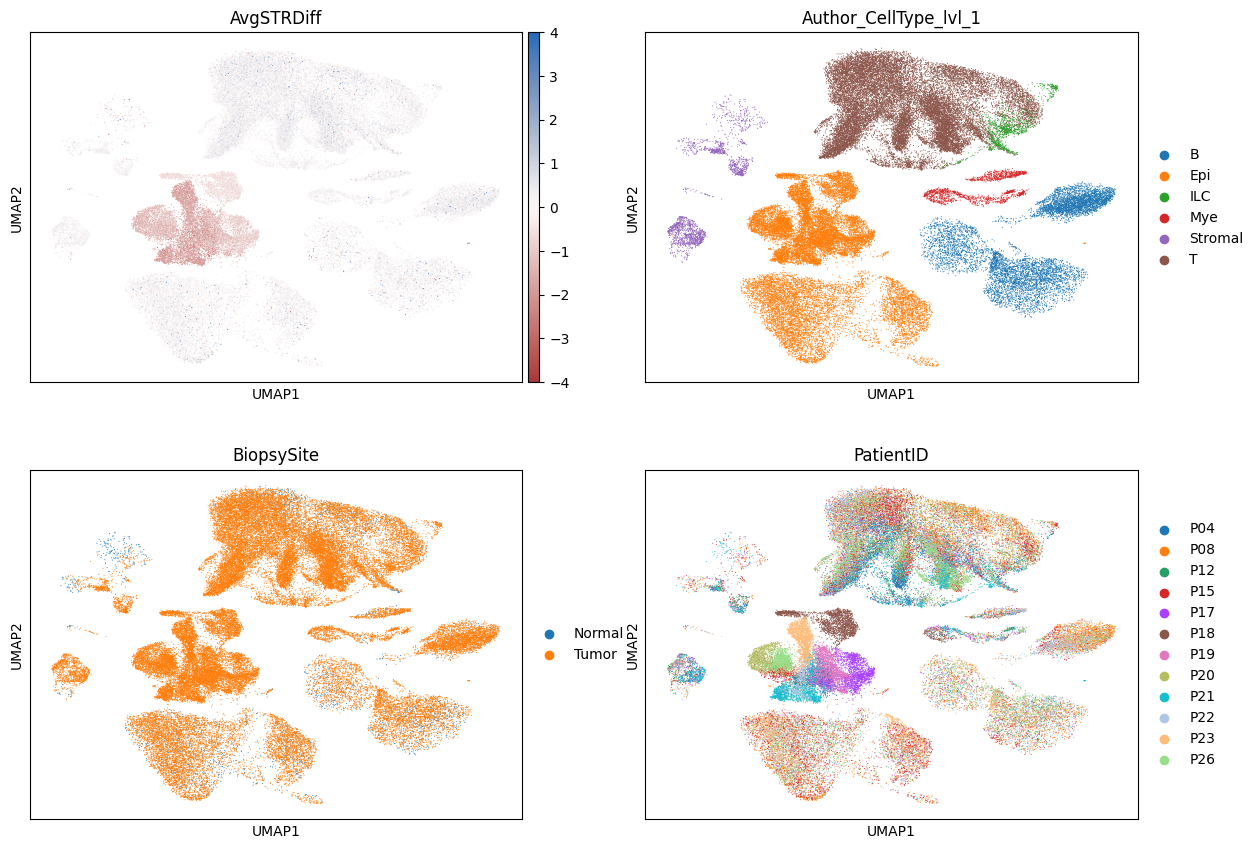

In [25]:
sc.pl.umap(adata[adata.obs['NumSTRLoci']!=0], color=['AvgSTRDiff', 'Author_CellType_lvl_1', 'BiopsySite', 'PatientID'], 
           ncols=2,
           cmap='vlag_r', vmin=-4, vmax=4)

In [9]:
adata.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.h5ad')

## Joanito et al

In [154]:
joanito_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
joanito_metadata = joanito_metadata[joanito_metadata['dataset'].isin(['CRC-SG1', 'KUL5', 'KUL3'])].copy()

PATH_SG1_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/EGAD00001008555-metadata/organized_metadata.tsv"
PATH_KUL_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/organized_metadata.tsv"

SG1_metadata = pd.read_csv(PATH_SG1_metadata, sep='\t')
KUL_metadata = pd.read_csv(PATH_KUL_metadata, sep='\t')

SG1_metadata = SG1_metadata[SG1_metadata['patient.ID'].isin( joanito_metadata['patient.ID'] )].copy()
KUL_metadata = KUL_metadata[KUL_metadata['patient.ID'].isin( joanito_metadata['patient.ID'] )].copy()

In [135]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.h5ad')

In [141]:
DIR_KUL_MSI_cellranger_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger'
DIR_KUL_MSS_cellranger_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/iCMS3_MSS'
DIR_SG1_cellranger_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/cellranger'

set_SampleID = set()
for d in glob.glob(f'{DIR_KUL_MSI_cellranger_out}/*'):
    if os.path.isdir(d)==False: continue
    set_SampleID.add( d.split('/')[-1] )
for d in glob.glob(f'{DIR_KUL_MSS_cellranger_out}/*'):
    if os.path.isdir(d)==False: continue
    set_SampleID.add( d.split('/')[-1] )
for d in glob.glob(f'{DIR_SG1_cellranger_out}/*'):
    if os.path.isdir(d)==False: continue
    set_SampleID.add( d.split('/')[-1] )

### Process NanoMnT outputs (Tumor & NAT share same directories)

In [187]:
# Check if NanoMnT has been processed for all samples
for SampleID in set(adata.obs.SampleID):
    if os.path.exists(f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    elif os.path.exists(f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    elif os.path.exists(f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    else:
        print(f'Allele table not found for:\t{SampleID}')

In [193]:
alleleTable = list()

for SampleID in set(adata.obs.SampleID):
    if os.path.exists(f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_KUL_MSI_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    elif os.path.exists(f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_KUL_MSS_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    elif os.path.exists(f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv')==True:
        PATH_alleleTable            = f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.tsv'
        PATH_processed_alleleTable  = f'{DIR_SG1_cellranger_out}/{SampleID}/outs/possorted_genome_bam.STR_allele_table.preprocessed.tsv'
    else:
        print(f'Allele table not found for:\t{SampleID}')
        continue
        
    if os.path.exists(PATH_processed_alleleTable) == True:
        alleleTable_temp = pd.read_csv(PATH_processed_alleleTable, sep='\t')
        alleleTable.append(alleleTable_temp)
    
    elif os.path.exists(PATH_alleleTable) == True:
        alleleTable_temp = pd.read_csv(PATH_alleleTable, sep='\t')
        alleleTable_temp['SampleID'] = SampleID
        orig_length = len(alleleTable_temp)

        ### 1. Filter out low-quality flankings (e.g., indels within flankings)        
        col_flanking_quality = list()
        for tup2 in alleleTable_temp.itertuples():
            bf = f'{tup2.left_flanking_seq}{tup2.right_flanking_seq}'
            if '*' in bf:
                col_flanking_quality.append( 'Poor' )
            elif bf.upper() != bf:
                col_flanking_quality.append( 'Poor' )
            else:
                col_flanking_quality.append( 'Good' )
                
        alleleTable_temp['flanking_quality'] = col_flanking_quality
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['flanking_quality']=='Good')].copy()
        
        ### 2. Filter out G/C repeats
        alleleTable_temp = alleleTable_temp[(alleleTable_temp['repeat_unit'].isin(['A', 'T']))].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')        
        
        ### 3. Filter out reads without CB or UMI
        alleleTable_temp.dropna(inplace=True,)
        alleleTable_temp = alleleTable_temp[alleleTable_temp['reference_STR_allele']<=24].copy()
        print(f'{round(100*len(alleleTable_temp)/orig_length, 2)} %')
        
        if 'read_STR_allele' not in alleleTable_temp.columns:
            alleleTable_temp.rename( {'read_STR_length' : 'read_STR_allele'}, axis=1, inplace=True )
        
        alleleTable_temp['diff'] = alleleTable_temp['read_STR_allele'] - alleleTable_temp['reference_STR_allele']
        alleleTable_temp.to_csv(PATH_processed_alleleTable, sep='\t', index=False)
        alleleTable.append(alleleTable_temp)

71.63 %
56.51 %
67.34 %
55.92 %
70.88 %
60.13 %
86.05 %
75.77 %
84.5 %
74.69 %
87.03 %
74.54 %
69.57 %
58.61 %
66.23 %
55.86 %
66.76 %
53.58 %
87.33 %
75.57 %
71.19 %
58.79 %
67.14 %
52.09 %
71.06 %
57.28 %
88.09 %
76.32 %
87.59 %
74.87 %
68.4 %
56.75 %
66.99 %
53.6 %
69.68 %
57.52 %
66.68 %
56.92 %
69.05 %
59.71 %
88.41 %
78.85 %
64.45 %
51.79 %
69.12 %
52.19 %
69.3 %
57.61 %
68.64 %
49.89 %
87.32 %
75.78 %
87.17 %
75.82 %
81.73 %
70.6 %
67.54 %
52.13 %
69.28 %
54.4 %
86.0 %
75.49 %
70.72 %
59.82 %
65.09 %
53.9 %
65.5 %
51.31 %
87.29 %
76.63 %
85.74 %
75.1 %
82.87 %
71.24 %
87.36 %
77.21 %
66.74 %
56.21 %
67.14 %
54.6 %
87.18 %
71.6 %
86.61 %
76.41 %
66.85 %
55.37 %
65.76 %
56.23 %
70.56 %
54.1 %
71.33 %
60.59 %
86.52 %
76.27 %
72.67 %
60.06 %
65.16 %
56.01 %
67.92 %
56.84 %
87.75 %
74.57 %


In [196]:
alleleTable = pd.concat(alleleTable)
alleleTable.reset_index(inplace=True, drop=True)

In [198]:
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB.split("-")[0]}' for tup in alleleTable.itertuples() ]

In [199]:
alleleTable.head(1)

,read_name,locus,repeat_unit,allele,reference_STR_allele,left_flanking_seq,right_flanking_seq,flag,CB,UMI,corrected_allele,editing_distance,read_STR_allele,SampleID,flanking_quality,diff,Identifier
0,K00250:342:H3HTNBBXY:5:1228:25784:16454,chr11:63977928-63977944,T,TTTTTTTTTTTTTTTTTTT,17,TAATGG,AAGTAG,16,ACGGCCAAGACGCTTT-1,CGGTACTTCG,TTTTTTTTTTTTTTTTTTT,0,19,XHC137,Good,2,XHC137-ACGGCCAAGACGCTTT


In [ ]:
alleleTable = pd.concat(alleleTable)
alleleTable.reset_index(inplace=True, drop=True)
alleleTable['Identifier'] = [ f'{tup.SampleID}-{tup.CB.split("-")[0]}' for tup in alleleTable.itertuples() ]

In [200]:
alleleTable.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', index=False, compression='gzip')

In [201]:
dict_Identifier_to_STRprofile = dict()

for Identifier, edf in alleleTable.groupby("Identifier"):
    edf_o = edf['diff'].dropna()
    if len(edf_o) > 0:
        dict_Identifier_to_STRprofile[Identifier] = [ np.mean(edf_o), np.std(edf_o), len(edf_o) ]

saveWithPickle(dict_Identifier_to_STRprofile, '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al', 'dict_Identifier_to_STRprofile')

### Overlay results

In [202]:
dict_Identifier_to_STRprofile   = loadFromPickle( '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/dict_Identifier_to_STRprofile.pickle' )
for Identifier in adata.obs['Identifier']:
    try: dict_Identifier_to_STRprofile[Identifier]
    except KeyError: dict_Identifier_to_STRprofile[Identifier]=[0, 0, 0]

In [203]:
adata.obs['AvgSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][0] for Identifier in adata.obs['Identifier'] ]
adata.obs['StdSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][1] for Identifier in adata.obs['Identifier'] ]
adata.obs['NumSTRLoci'] = [ dict_Identifier_to_STRprofile[Identifier][2] for Identifier in adata.obs['Identifier'] ]
adata.obs['MSI_score']  = -1 * adata.obs['AvgSTRDiff'] * adata.obs['StdSTRDiff']

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


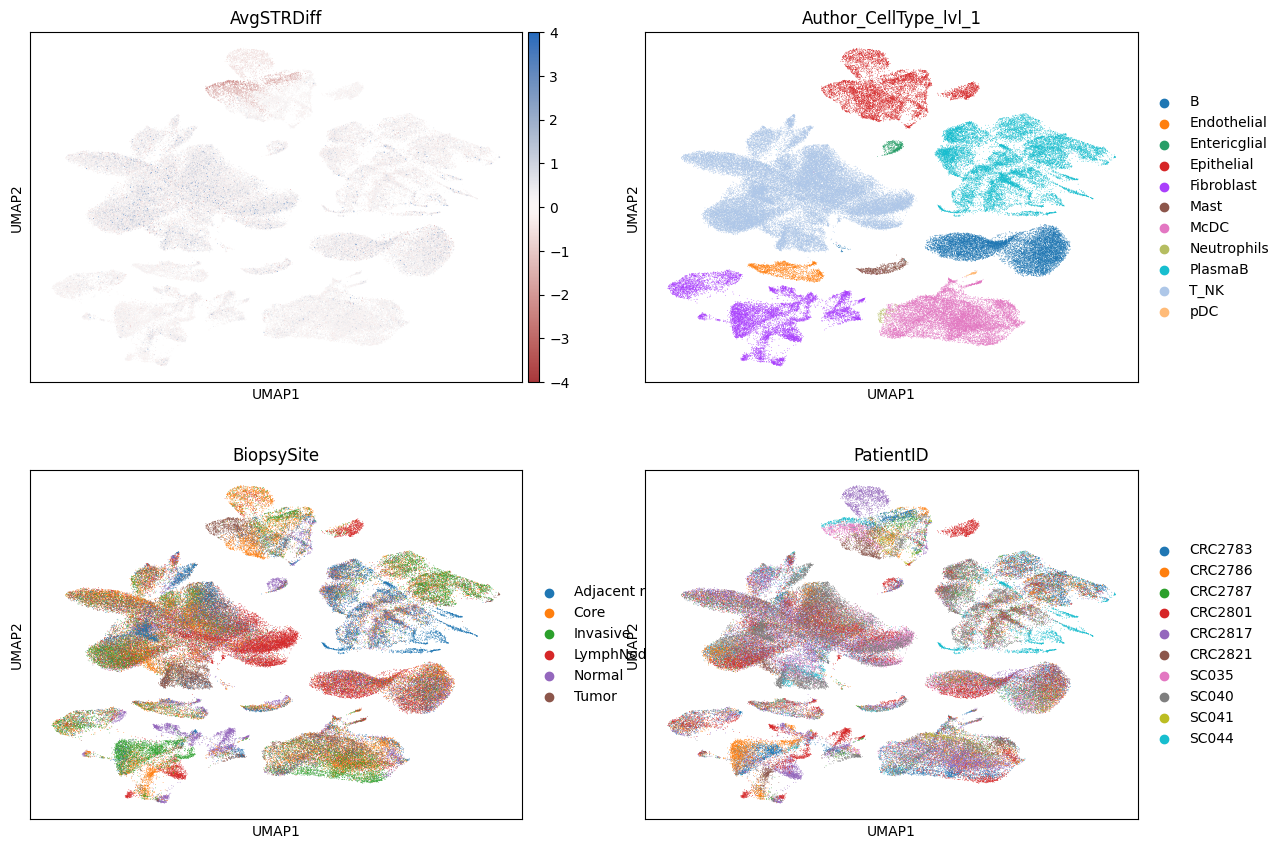

In [204]:
sc.pl.umap(adata[adata.obs['NumSTRLoci']!=0], color=['AvgSTRDiff', 'Author_CellType_lvl_1', 'BiopsySite', 'PatientID'], 
           ncols=2,
           cmap='vlag_r', vmin=-4, vmax=4)

In [12]:
adata.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.h5ad')